In [1]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

In [2]:
# from PIL import Image
# import os
# import json

# # Répertoire des images et taille cible
# input_folder = "train"
# output_folder = "images_resized"
# os.makedirs(output_folder, exist_ok=True)

# target_size = (256,256)  # (width, height)

# # Charger les annotations COCO
# with open("_annotations.coco.json", "r") as f:
#     coco_data = json.load(f)

# # Créer un dictionnaire rapide pour retrouver les annotations par image_id
# annotations_by_image = {}
# for ann in coco_data["annotations"]:
#     img_id = ann["image_id"]
#     annotations_by_image.setdefault(img_id, []).append(ann)

# # Parcourir les images et redimensionner + ajuster les annotations
# for img_info in coco_data["images"]:
#     filename = img_info["file_name"]
#     image_path = os.path.join(input_folder, filename)
#     resized_path = os.path.join(output_folder, filename)

#     if not os.path.exists(image_path):
#         print(f"Image manquante : {filename}")
#         continue

#     # Ouvrir l’image et obtenir taille originale
#     with Image.open(image_path) as img:
#         original_width, original_height = img.size
#         resized_img = img.resize(target_size)
#         resized_img.save(resized_path)

#     # Calcul des facteurs d’échelle
#     scale_x = target_size[0] / original_width
#     scale_y = target_size[1] / original_height

#     # Mise à jour dans le JSON
#     img_info["width"] = target_size[0]
#     img_info["height"] = target_size[1]

#     for ann in annotations_by_image.get(img_info["id"], []):
#         x, y, w, h = ann["bbox"]
#         ann["bbox"] = [
#             x * scale_x,
#             y * scale_y,
#             w * scale_x,
#             h * scale_y
#         ]

# # Sauvegarder le nouveau fichier JSON
# with open("annotation_resized.json", "w") as f:
#     json.dump(coco_data, f)

# print("✅ Redimensionnement terminé avec succès.")


In [3]:
import json
import pandas as pd

# Charger le fichier JSON
with open('annotation_resized.json') as f:
    data = json.load(f)

# Extraire les parties importantes
images = {img['id']: img for img in data['images']}
categories = {cat['id']: cat['name'] for cat in data['categories']}

# Préparer une liste des lignes
rows = []

for ann in data['annotations']:
    image = images[ann['image_id']]
    row = {
        'image_id': image['file_name'],
        'width': image['width'],
        'height': image['height'],
        'bbox': ann['bbox'],  # [x, y, width, height]
        'category': categories[ann['category_id']]
    }
    rows.append(row)

# Créer le DataFrame
df = pd.DataFrame(rows)

# Sauvegarder en CSV
df.to_csv('annotations.csv', index=False)

# Aperçu
print(df.head())


                                            image_id  width  height  \
0  CarLongPlateGen1204_jpg.rf.737a7d786c35827d289...    256     256   
1  CarLongPlateGen1207_jpg.rf.43e238ac1de95e78ab1...    256     256   
2  CarLongPlateGen11_jpg.rf.f1bd885f4e4acc0a68a0e...    256     256   
3  CarLongPlateGen1277_jpg.rf.7f949488fdd52417f8e...    256     256   
4  CarLongPlateGen1200_jpg.rf.43b1c62e4284758ed27...    256     256   

                                                bbox       category  
0  [120.40677966101696, 180.8052805280528, 53.152...  License_Plate  
1  [107.38983050847457, 204.46204620462046, 60.20...  License_Plate  
2  [99.2542372881356, 110.67986798679868, 36.8813...  License_Plate  
3  [71.05084745762711, 118.28382838283828, 61.830...  License_Plate  
4  [171.38983050847457, 104.76567656765677, 32.0,...  License_Plate  


In [4]:
train=pd.read_csv('annotations.csv')

In [5]:
train

,image_id,width,height,bbox,category
0,CarLongPlateGen1204_jpg.rf.737a7d786c35827d289...,256,256,"[120.40677966101696, 180.8052805280528, 53.152...",License_Plate
1,CarLongPlateGen1207_jpg.rf.43e238ac1de95e78ab1...,256,256,"[107.38983050847457, 204.46204620462046, 60.20...",License_Plate
2,CarLongPlateGen11_jpg.rf.f1bd885f4e4acc0a68a0e...,256,256,"[99.2542372881356, 110.67986798679868, 36.8813...",License_Plate
3,CarLongPlateGen1277_jpg.rf.7f949488fdd52417f8e...,256,256,"[71.05084745762711, 118.28382838283828, 61.830...",License_Plate
4,CarLongPlateGen1200_jpg.rf.43b1c62e4284758ed27...,256,256,"[171.38983050847457, 104.76567656765677, 32.0,...",License_Plate
...,...,...,...,...,...
7352,CarLongPlate677_jpg.rf.35798ac3927598664ae88f0...,256,256,"[130.16949152542372, 185.02970297029702, 56.94...",License_Plate
7353,IMG_7084-conv_jpeg_jpg.rf.c52073968cb9a90fcff4...,256,256,"[66.62433862433862, 91.42857142857142, 106.143...",License_Plate
7354,xemay2065_jpg.rf.814292dfee5a5c4d5db45bba5a798...,256,256,"[138.84745762711864, 115.74917491749176, 24.40...",License_Plate
7355,CarLongPlateGen2398_jpg.rf.eede8e77b964cc503cd...,256,256,"[86.23728813559322, 57.45214521452145, 69.4237...",License_Plate


In [6]:
coords = pd.DataFrame(
    list(train.bbox.apply(lambda x: x[1:-1].split(",")).values),
    columns=["x1", "y1", "w", "h"]
)

In [7]:
df=pd.concat([train,coords],axis=1)

In [8]:
df["x1"]=pd.to_numeric(df["x1"])
df["y1"]=pd.to_numeric(df["y1"])
df["w"]=pd.to_numeric(df["w"])
df["h"]=pd.to_numeric(df["h"])

In [9]:
df["x2"]=df["x1"]+df["w"]
df["y2"]=df["y1"]+df["h"]

In [10]:
df.drop(["bbox","width","height","w","h","category"],axis=1,inplace=True)

In [11]:
df.head()

,image_id,x1,y1,x2,y2
0,CarLongPlateGen1204_jpg.rf.737a7d786c35827d289...,120.406780,180.805281,173.559322,207.841584
1,CarLongPlateGen1207_jpg.rf.43e238ac1de95e78ab1...,107.389831,204.462046,167.593220,234.877888
2,CarLongPlateGen11_jpg.rf.f1bd885f4e4acc0a68a0e...,99.254237,110.679868,136.135593,122.508251
3,CarLongPlateGen1277_jpg.rf.7f949488fdd52417f8e...,71.050847,118.283828,132.881356,139.405941
4,CarLongPlateGen1200_jpg.rf.43b1c62e4284758ed27...,171.389831,104.765677,203.389831,125.042904


In [12]:
unique_imgs=df.image_id.unique()

In [13]:
unique_imgs

array(['CarLongPlateGen1204_jpg.rf.737a7d786c35827d289cb11cd5737288.jpg',
       'CarLongPlateGen1207_jpg.rf.43e238ac1de95e78ab1c18b26ce576a5.jpg',
       'CarLongPlateGen11_jpg.rf.f1bd885f4e4acc0a68a0e1c3c13c0a5a.jpg',
       ..., 'xemay2065_jpg.rf.814292dfee5a5c4d5db45bba5a798159.jpg',
       'CarLongPlateGen2398_jpg.rf.eede8e77b964cc503cd868d5012e47a5.jpg',
       'CarLongPlateGen540_jpg.rf.95a8b2081c7a4ebfeb00af497e6cda52.jpg'],
      dtype=object)

In [14]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
        self.transform = T.Compose([
          T.ToTensor()             # Convertir en Tensor
        ])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float32")

        # Charger l'image
        image_path = os.path.join("images_resized", image_name)
        img = Image.open(image_path).convert('RGB')

        # Appliquer la transformation (resize + ToTensor)
        img = self.transform(img)

        # Créer les labels (1 classe → "plaque")
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        # Créer le dictionnaire cible attendu par Faster R-CNN
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "label": labels
        }

        return img, target


In [15]:
train_inds, val_inds = train_test_split(range(unique_imgs.shape[0]), test_size=0.1, random_state=42)

In [16]:
def custom_collate(data):
    return data

In [17]:
train_dl = torch.utils.data.DataLoader(
    dataset=CustDat(df, unique_imgs, train_inds),
    batch_size=6,
    shuffle=True,
    collate_fn=custom_collate,
    pin_memory=torch.cuda.is_available()
)

val_dl = torch.utils.data.DataLoader(
    dataset=CustDat(df, unique_imgs, val_inds),
    batch_size=6,
    shuffle=True,
    collate_fn=custom_collate,
    pin_memory=torch.cuda.is_available()
)

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

C:\Users\Gigabyte\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gigabyte\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [35]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0005)

num_epochs = 3

In [37]:
import matplotlib.pyplot as plt

model.to(device)
best_loss = float('inf')
losses = []  # Store loss for each epoch

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for i, data in enumerate(tqdm(train_dl, desc=f"Epoch {epoch+1}")):
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {
                "boxes": d[1]["boxes"].to(device),
                "labels": d[1]["label"].to(device)
            }
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(epoch_loss)
    print(f"Epoch {epoch+1} finished. Total Loss: {epoch_loss:.4f}")

    # Save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        save_path = "best_fasterrcnn_mobilenet.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss
        }, save_path)
        print(f"✅ Nouveau meilleur modèle sauvegardé : {save_path}")
    else:
        print("📉 Pas une meilleure performance, modèle non sauvegardé.")

# 📈 Plot and save the loss curve
plt.figure()
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-')
plt.title("Évolution de la fonction de perte")
plt.xlabel("Époque")
plt.ylabel("Perte totale")
plt.grid(True)
plt.savefig("loss_curve.png")
plt.close()
print("📷 Courbe de perte sauvegardée dans 'loss_curve.png'")
torch.cuda.empty_cache()

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1058/1058 [13:33<00:00,  1.30it/s]


Epoch 1 finished. Total Loss: 19.2845
✅ Nouveau meilleur modèle sauvegardé : best_fasterrcnn_mobilenet.pth


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1058/1058 [12:51<00:00,  1.37it/s]


Epoch 2 finished. Total Loss: 19.0564
✅ Nouveau meilleur modèle sauvegardé : best_fasterrcnn_mobilenet.pth


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1058/1058 [12:51<00:00,  1.37it/s]


Epoch 3 finished. Total Loss: 19.0342
✅ Nouveau meilleur modèle sauvegardé : best_fasterrcnn_mobilenet.pth
📷 Courbe de perte sauvegardée dans 'loss_curve.png'


In [20]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.version.cuda)  # Should show your CUDA version

True
12.1


In [22]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ⚙️ Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 🔁 Load the model and modify the predictor
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)



# 🔄 Load the checkpoint
checkpoint = torch.load("best_fasterrcnn_mobilenet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']  # Should be 30
best_loss = checkpoint['loss']

# 💡 Load optimizer and move state tensors to the correct device
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# 📈 Load previous losses if available
try:
    with open("loss_history.txt", "r") as f:
        losses = [float(line.strip()) for line in f]
except FileNotFoundError:
    print("⚠️ Previous loss history file not found. Starting a new one.")
    losses = []

# 🚀 Resume training
num_epochs = 31
model.to(device)

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0
    for i, data in enumerate(tqdm(train_dl, desc=f"Epoch {epoch+1}")):
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {
                "boxes": d[1]["boxes"].to(device),
                "labels": d[1]["label"].to(device)
            }
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(epoch_loss)
    print(f"📅 Epoch {epoch+1} finished. Total Loss: {epoch_loss:.4f}")

    # 💾 Save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        save_path = "best_fasterrcnn_mobilenet.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss
        }, save_path)
        print(f"✅ Nouveau meilleur modèle sauvegardé : {save_path}")
    else:
        print("📉 Pas une meilleure performance, modèle non sauvegardé.")
torch.cuda.empty_cache()

# predciction de plaque image

C:\Users\Gigabyte\anaconda3\envs\datamining\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gigabyte\anaconda3\envs\datamining\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_11696\690261396.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defaul

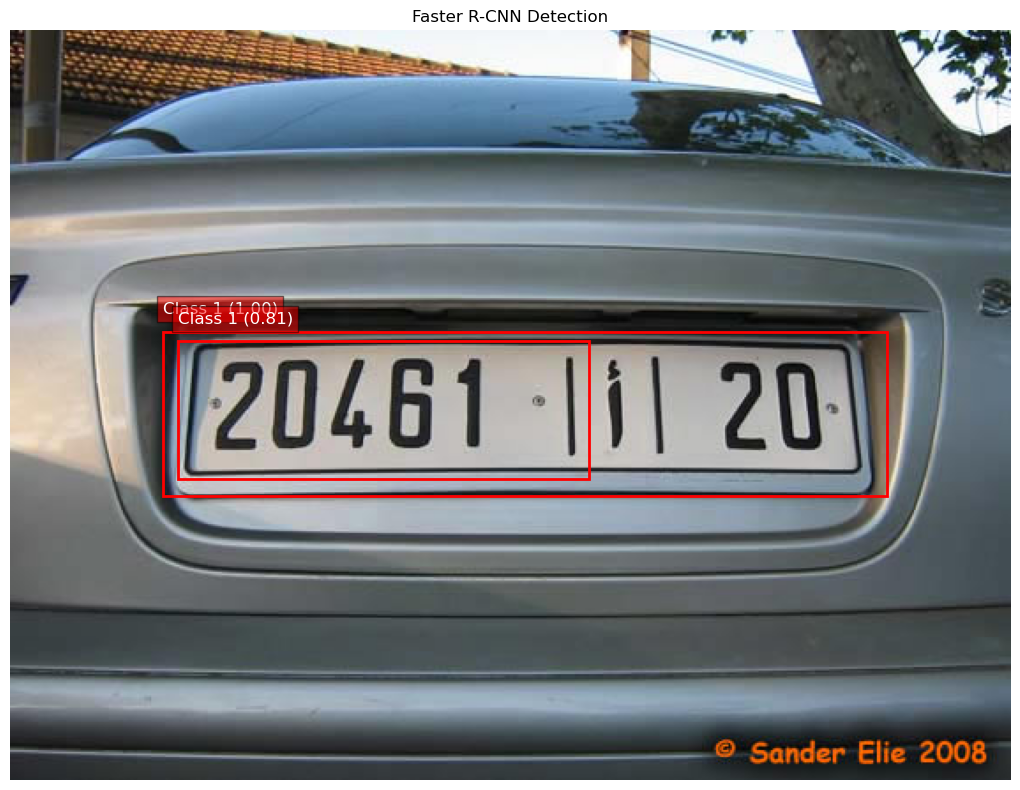

In [8]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ⚙️ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # 1 class + background

# 🔁 Load trained model
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint = torch.load("best_fasterrcnn_mobilenet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 🖼️ Load and transform the test image
image_path = r"C:\Users\Gigabyte\OneDrive\Images\test\P02026.jpeg"  # 🔁 Change this to your image path
img = Image.open(image_path).convert("RGB")

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img).to(device)

# 🔍 Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# 📦 Visualize results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)
threshold = 0.6  # Confidence threshold
label_map = {
    1: "license plate"
}

for box, label, score in zip(prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu()):
    if score >= threshold:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_name = label_map.get(label.item(), f"Class {label.item()}")
        ax.text(xmin, ymin - 10, f"Class {label.item()} ({score:.2f})",
                color='white', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))


plt.axis('off')
plt.title("Faster R-CNN Detection")
plt.tight_layout()
plt.show()



In [9]:
torch.cuda.empty_cache()
print(f"Mémoire GPU allouée : {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Mémoire GPU réservée : {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Mémoire GPU allouée : 589.72 MB
Mémoire GPU réservée : 600.00 MB


In [12]:
import easyocr
import cv2
import numpy as np

# Charger le modèle EasyOCR
reader = easyocr.Reader(['fr','en'])  # tu peux ajouter 'fr' si nécessaire


In [13]:
# Convertir l'image PIL en format OpenCV (numpy array)
img_cv2 = np.array(img)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR)  # convert to BGR

for box, label, score in zip(prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu()):
    if score >= threshold:
        xmin, ymin, xmax, ymax = map(int, box)
        
        # Dessiner la boîte
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Extraire la région de la plaque
        plate_region = img_cv2[ymin:ymax, xmin:xmax]
        
        # OCR sur la région extraite
        result = reader.readtext(plate_region)
        
        # Afficher le texte détecté
        if result:
            text = result[0][1]  # premier résultat, deuxième élément est le texte
            print(f"Texte détecté : {text}")
            
            # Afficher sur l'image
            ax.text(xmin, ymin - 10, f"{text} ({score:.2f})",
                    color='white', fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5))


Texte détecté : 20461 '|11 20
Texte détecté : 20461


C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_18156\1790309967.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_fasterrcnn_mobilenet.pth",

Texte détecté : SLE593LM


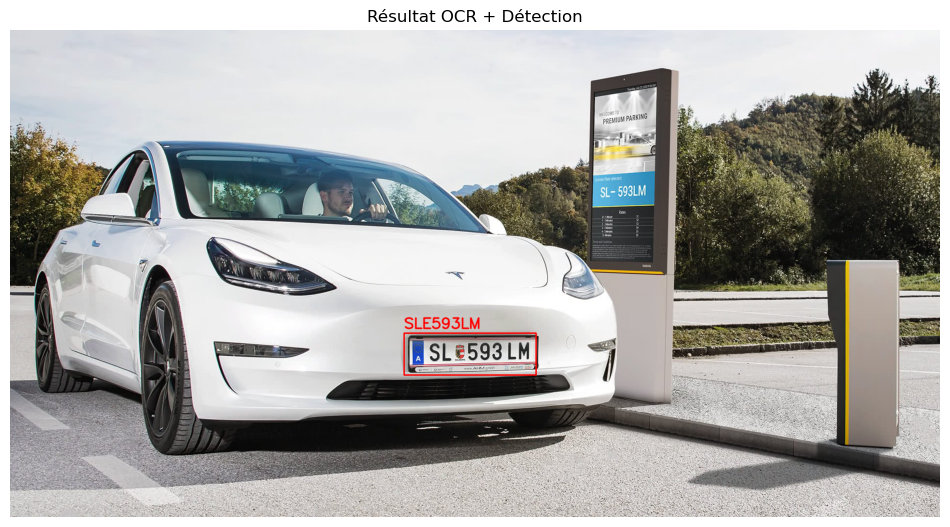

True

In [3]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import easyocr
import cv2
import numpy as np

# ⚙️ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # 1 class + background

# 🔁 Load trained model
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint = torch.load("best_fasterrcnn_mobilenet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 🖼️ Load and transform the test image
image_path = r"C:\Users\Gigabyte\OneDrive\Images\test\lpr-tesla-license-plate-recognition-1910x1000.jpg"
img = Image.open(image_path).convert("RGB")

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img).to(device)

# 🔍 Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# 📖 Setup OCR
reader = easyocr.Reader(['fr','en'])

# Convert image for OpenCV
img_cv2 = np.array(img)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR)

# 🖍️ Draw results
threshold = 0.6
for box, label, score in zip(prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu()):
    if score >= threshold:
        xmin, ymin, xmax, ymax = map(int, box)

        # Dessiner rectangle autour de la plaque
        cv2.rectangle(img_cv2, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

        # Découper la plaque et appliquer OCR
        plate_crop = img_cv2[ymin:ymax, xmin:xmax]
        result = reader.readtext(plate_crop)

        if result:
            text = result[0][1]  # texte détecté
            print(f"Texte détecté : {text}")

            # Écrire le texte détecté sur l'image
            cv2.putText(img_cv2, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 0, 255), 2, cv2.LINE_AA)


# Convertir BGR (OpenCV) vers RGB (Matplotlib)
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Afficher avec matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Résultat OCR + Détection")
plt.show()
cv2.imwrite("resultat_detection_ocr.jpg", img_cv2)

# video optimise

In [2]:
import torch
import cv2
import numpy as np
import csv
from tqdm import tqdm
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import easyocr

# Configuration
device = torch.device("cuda")
num_classes = 2

# Charger modèle Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
checkpoint = torch.load("best_fasterrcnn_mobilenet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# EasyOCR
reader = easyocr.Reader(['fr', 'en'])

# Chargement de la vidéo
video_path = r"C:\Users\Gigabyte\Videos\20250513_135456.mp4"
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Sortie vidéo
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('result_video_tetouan.mp4', fourcc, fps, (width, height))

# Préparation CSV
csv_file = open("detections.csv", mode='w', newline='', encoding='utf-8')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["Frame", "Text", "Xmin", "Ymin", "Xmax", "Ymax"])

# Transform
transform = transforms.Compose([transforms.ToTensor()])
threshold = 0.9

# Traiter 1 frame sur 3
frame_skip = 1
frame_count = 0

# tqdm pour barre de progression
pbar = tqdm(total=total_frames, desc="Traitement vidéo optimisé")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    pbar.update(1)

    if frame_count % frame_skip != 0:
        out.write(frame)
        continue

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).to(device)

    with torch.no_grad():
        prediction = model([img_tensor])[0]

    for box, label, score in zip(prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu()):
        if score >= threshold:
            xmin, ymin, xmax, ymax = map(int, box)
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

            plate_crop = frame[ymin:ymax, xmin:xmax]
            result = reader.readtext(plate_crop)

            if result:
                text = result[0][1]
                cv2.putText(frame, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.9, (0, 255, 0), 2, cv2.LINE_AA)
                csv_writer.writerow([frame_count, text, xmin, ymin, xmax, ymax])

    out.write(frame)

# Nettoyage
pbar.close()
cap.release()
out.release()
csv_file.close()


C:\Users\Gigabyte\anaconda3\envs\datamining\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gigabyte\anaconda3\envs\datamining\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_16572\2289753073.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defau

In [34]:
torch.cuda.empty_cache()

In [52]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision import transforms
from pycocotools.cocoeval import COCOeval
import json
import os
from tqdm import tqdm

# 📁 Paths
images_dir = "test"  # <-- Dossier contenant les images
annotation_path = "_annotations_test.coco.json"  # <-- Fichier COCO JSON
model_path = "best_fasterrcnn_mobilenet.pth"

# ⚙️ Device
device = torch.device("cuda")

# 🔁 Transformations
transform = transforms.Compose([transforms.ToTensor()])

# 📚 Dataset
dataset = CocoDetection(images_dir, annotation_path, transform=transform)

# 🧠 Charger modèle
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 📤 Inference + format COCO
results = []
image_ids = []

print("🔎 Inference sur dataset...")

for idx in tqdm(range(len(dataset))):
    img, target = dataset[idx]
    if len(target) == 0:
        continue  # skip les images sans annotations
    img_id = target[0]['image_id']

    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    boxes = prediction["boxes"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        coco_result = {
            "image_id": int(img_id),
            "category_id": int(label),
            "bbox": [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],
            "score": float(score)
        }
        results.append(coco_result)
    image_ids.append(int(img_id))

# 💾 Sauver résultats
with open("coco_predictions.json", "w") as f:
    json.dump(results, f, indent=2)

# 📈 Évaluation avec pycocotools
from pycocotools.coco import COCO
coco_gt = COCO(annotation_path)
coco_dt = coco_gt.loadRes("coco_predictions.json")

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_9024\2315223727.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


🔎 Inference sur dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1020/1020 [01:47<00:00,  9.49it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [6]:
import os
import random
import cv2
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from PIL import Image
import easyocr

# 📂 Chemins
test_images_dir = r"C:\Users\Gigabyte\Desktop\datamining\deeplearning FORMASYS\1License Plate Recognition.v11i.coco\test"
output_dir = "output_detected"
os.makedirs(output_dir, exist_ok=True)

# ⚙️ Appareil
device = torch.device('cuda')

# 🧠 EasyOCR
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

# 🔠 Prétraitement
transform = transforms.Compose([
    transforms.ToTensor()
])

# 📦 Charger le modèle
num_classes = 2  # 1 classe plaque + fond
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
checkpoint = torch.load("best_fasterrcnn_mobilenet.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 🎯 Sélectionner 30 images aléatoires
all_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_images = random.sample(all_images, min(100, len(all_images)))

# 🔁 Boucle sur les images
for img_name in sample_images:
    img_path = os.path.join(test_images_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Prédiction
    with torch.no_grad():
        outputs = model(img_tensor)[0]

    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box, score in zip(outputs['boxes'], outputs['scores']):
        if score > 0.75:
            x1, y1, x2, y2 = map(int, box.tolist())
            roi = img_cv[y1:y2, x1:x2]

            # 🧠 OCR avec EasyOCR
            result = reader.readtext(roi)
            if result:
                text = result[0][1].strip()
                if text:
                    # 🖼️ Dessiner
                    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img_cv, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                                0.9, (0, 0, 255), 2, cv2.LINE_AA)

    # 💾 Sauvegarder l'image annotée
    cv2.imwrite(os.path.join(output_dir, f"annotated_{img_name}"), img_cv)

print(f"✅ 30 images annotées enregistrées dans : {output_dir}")


C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_18156\3477585146.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_fasterrcnn_mobilenet.pth",

✅ 30 images annotées enregistrées dans : output_detected


In [11]:
torch.cuda.empty_cache()